<a href="https://colab.research.google.com/github/ilombard20238/AiRetail1/blob/main/AiRetail1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cloning github

In [22]:
!git clone https://github.com/ilombard20238/AiRetail1.git


fatal: destination path 'AiRetail1' already exists and is not an empty directory.


In [23]:
import os
print(os.listdir("/content/AiRetail1"))  # should show your AiRetail folder
print(os.listdir("/content/AiRetail1/AiRetail"))  # should show 'train' and 'test'


['AiRetail', '.git', 'README.md', 'AiRetail1.ipynb']
['testing', '.gitkeep', 'training']


In [24]:
data_dir = "/content/AiRetail1/AiRetail"
train_dir = f"{data_dir}/training"
test_dir  = f"{data_dir}/testing"

print("Train exists?", os.path.exists(train_dir))
print("Test exists?", os.path.exists(test_dir))


Train exists? True
Test exists? True


In [25]:
data_dir = "/content/AiRetail1/AiRetail"
train_dir = f"{data_dir}/training"
test_dir  = f"{data_dir}/testing"

print("Train exists?", os.path.exists(train_dir))
print("Test exists?", os.path.exists(test_dir))


Train exists? True
Test exists? True


# organizing the files

In [26]:
import os
import shutil

# Set paths
data_dir = "/content/AiRetail1/AiRetail"
for folder in ["training", "testing"]:
    folder_path = os.path.join(data_dir, folder)
    if not os.path.exists(folder_path):
        print(f"{folder_path} does not exist!")
        continue

    # List all images in current folder
    images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg','.png'))]

    for img in images:
        # Get class name from filename (everything before .jpg)
        class_name = os.path.splitext(img)[0]

        # Make class folder if it doesn't exist
        class_folder = os.path.join(folder_path, class_name)
        os.makedirs(class_folder, exist_ok=True)

        # Move image into class folder
        src_path = os.path.join(folder_path, img)
        dst_path = os.path.join(class_folder, img)
        shutil.move(src_path, dst_path)

print("Dataset reorganized successfully!")


Dataset reorganized successfully!


#alexnet with W&B





Using device: cpu
Classes: ['bag1', 'bag2', 'hat1', 'hat2', 'shoe1', 'shoe2']


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipython-input-1852929266.py:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-1852929266.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch [1/5]  Loss: 1.1344  Val Acc: 85.83%
Epoch [2/5]  Loss: 0.3884  Val Acc: 94.17%
Epoch [3/5]  Loss: 0.1707  Val Acc: 99.17%
Epoch [4/5]  Loss: 0.0494  Val Acc: 100.00%
Epoch [5/5]  Loss: 0.0175  Val Acc: 100.00%
Model saved!


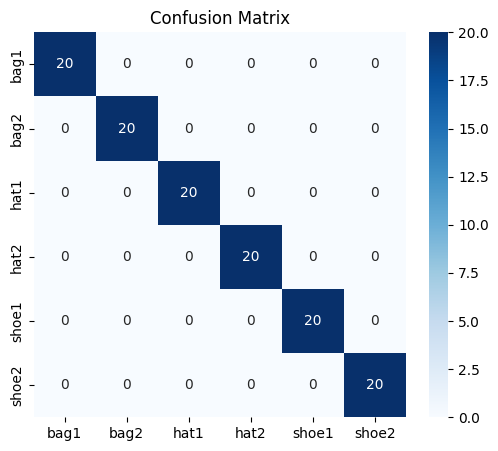

loss,█▃▂▁▁
val_acc,▁▅███
loss,0.01753
val_acc,1


In [27]:
 # ----------------------------------------------------
# 0️⃣ Install W&B
# ----------------------------------------------------
!pip install wandb -q

# ----------------------------------------------------
# 1️⃣ Imports
# ----------------------------------------------------
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ----------------------------------------------------
# 2️⃣ W&B Init
# ----------------------------------------------------
wandb.finish()
wandb.login()

wandb.init(
    project="AiRetail-AlexNet",
    name="alexnet-fast-cpu",
    config={
        "epochs": 5,              # ⬅️ fewer epochs (fast)
        "batch_size": 16,         # ⬅️ large batch improves CPU speed
        "learning_rate": 5e-4,
        "optimizer": "Adam",
        "architecture": "AlexNet (Frozen layers)",
    },
    reinit=True
)

# ----------------------------------------------------
# 3️⃣ Device
# ----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------------------------------
# 4️⃣ Paths + DataLoaders
# ----------------------------------------------------
data_dir = "/content/AiRetail1/AiRetail"
train_dir = os.path.join(data_dir, "training")
val_dir   = os.path.join(data_dir, "testing")

assert os.path.exists(train_dir)
assert os.path.exists(val_dir)

# ⚡ Faster transforms for CPU
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir, transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=wandb.config.batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=wandb.config.batch_size, num_workers=2)

class_names = train_ds.classes
print("Classes:", class_names)

# ----------------------------------------------------
# 5️⃣ AlexNet Model (Frozen)
# ----------------------------------------------------
model = models.alexnet(pretrained=True)

# ❄️ Freeze convolutional layers (80% faster on CPU)
for param in model.features.parameters():
    param.requires_grad = False

# Replace final layer
num_classes = len(class_names)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

model = model.to(device)

# ----------------------------------------------------
# 6️⃣ Loss + Optimizer
# ----------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=wandb.config.learning_rate)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# ----------------------------------------------------
# 7️⃣ FAST Training Loop
# ----------------------------------------------------
num_epochs = wandb.config.epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision if GPU, float32 if CPU
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # ---------------- Validation ----------------
    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}]"
          f"  Loss: {avg_loss:.4f}"
          f"  Val Acc: {val_acc*100:.2f}%")

    wandb.log({"loss": avg_loss, "val_acc": val_acc})

# ----------------------------------------------------
# 8️⃣ Save model
# ----------------------------------------------------
torch.save(model.state_dict(), "alexnet_retailAI_fast.pth")
wandb.save("alexnet_retailAI_fast.pth")
print("Model saved!")

# ----------------------------------------------------
# 9️⃣ Confusion Matrix
# ----------------------------------------------------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()

wandb.finish()
